<br>

## Installlation and imports

In [ ]:
!pip install -q transformers sentencePiece

     |████████████████████████████████| 3.8 MB 12.0 MB/s 
     |████████████████████████████████| 1.2 MB 40.4 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
     |████████████████████████████████| 596 kB 37.2 MB/s 
     |████████████████████████████████| 6.5 MB 35.8 MB/s 


In [ ]:
import re
import os
import time
import torch
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from transformers import AlbertTokenizer, AutoModel, pipeline

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from torch.utils.data import Dataset, DataLoader

<br>

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>

## Load data

In [ ]:
# fname = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/data/postprocessedECnumToSeq-edited.csv' #Tomas dir
fname = '/content/drive/MyDrive/Colab Notebooks/Protein Sequence Analysis/postprocessedECnumToSeq-edited.csv' #Rana dir
seq_data = pd.read_csv(
    fname, 
    index_col = 0    
)

In [ ]:
seq_data.head()

,EC Number,Level 1,Level 2,Level 3,Level 4,sequence
0,1,1,NaN,NaN,NaN,TKDNLTGDIVIIGAGAAGSLLAHYLARFSNMKIILLEAGHSHFNDP...
1,1,1,NaN,NaN,NaN,MHHHHHHSSGVDLGTENLYFQSNAMNISRKTALVTGASRGIGRAIA...
2,1,1,NaN,NaN,NaN,QGMIMTSDIKLLDYLRVRRSTPALQLSEPGPSKGEIEEILRLAVRV...
3,1,1,NaN,NaN,NaN,AMVSSSCSSIPKMPVTPLSLVTRHVAIIGAGAAGLVTARELRREGH...
4,1,1,NaN,NaN,NaN,MADLNQRRQRSEFQSKIKILLSTTIKAKPELVPSLLKLALNDAMTY...


In [ ]:
print(seq_data.shape)

(16994, 6)


<br>

## Perform data pre-processing

<br>

Subset columns

In [ ]:
cols = ['EC Number', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'sequence']
seq_data = seq_data[cols]

<br>

Change column names

In [ ]:
seq_data.columns = ['ECNumber', 'Level_1', 'Level_2', 'Level_3', 'Level_4', 'sequence']

<br>

Drop NaNs

In [ ]:
seq_data = seq_data.dropna(subset = ['sequence'])

<br>

Add column with sequence length

In [ ]:
seq_data['seg_length'] = seq_data['sequence'].apply(len)

<br>

Plot histogram of sequence length and highlight the threshold

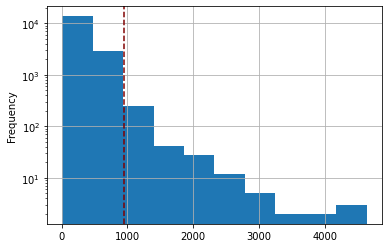

In [ ]:
length_th = 950
seq_data['seg_length'].plot.hist()
plt.axvline(length_th, ls = '--', color = 'maroon')
plt.yscale('log')
plt.grid()
plt.show()

<br>

Filter data by length

In [ ]:
seq_data = seq_data[seq_data['seg_length'] <= length_th]

In [ ]:
ec_encoder = LabelEncoder()
seq_data.loc[:,'ECLabel'] = ec_encoder.fit_transform(seq_data['ECNumber'])

In [ ]:
print(seq_data.shape)

(16660, 8)


In [ ]:
seq_data.head()

,ECNumber,Level_1,Level_2,Level_3,Level_4,sequence,seg_length,ECLabel
0,1,1,NaN,NaN,NaN,TKDNLTGDIVIIGAGAAGSLLAHYLARFSNMKIILLEAGHSHFNDP...,652,0
1,1,1,NaN,NaN,NaN,MHHHHHHSSGVDLGTENLYFQSNAMNISRKTALVTGASRGIGRAIA...,269,0
2,1,1,NaN,NaN,NaN,QGMIMTSDIKLLDYLRVRRSTPALQLSEPGPSKGEIEEILRLAVRV...,197,0
3,1,1,NaN,NaN,NaN,AMVSSSCSSIPKMPVTPLSLVTRHVAIIGAGAAGLVTARELRREGH...,458,0
4,1,1,NaN,NaN,NaN,MADLNQRRQRSEFQSKIKILLSTTIKAKPELVPSLLKLALNDAMTY...,268,0


<br>

## Initiate protAlbert tokenizer and model

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained(
    "Rostlab/prot_albert", 
    do_lower_case=False 
)

Downloading:   0%|          | 0.00/233k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

In [ ]:
albert_model = AutoModel.from_pretrained("Rostlab/prot_albert")

Downloading:   0%|          | 0.00/856M [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_albert were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<br>

## Perform sequence embedding

In [ ]:
class seqEmgedder():
    def __init__(self, model, tokenizer, sequences, device = 0):
        super().__init__()

        # Init pipeline
        self.pipeline = pipeline(
            'feature-extraction', 
            model = model, 
            tokenizer = tokenizer, 
            device=device
        )

        # Add sequences to class
        self.sequences = sequences

        # Number of sequences
        self.n = len(self.sequences)

    def batch_sequences(self, batch_size):
        for i in range(0, self.n, batch_size):
            yield self.sequences[i:i + batch_size]

    def get_average_embeddings(self, sequences, embeddings):
        average_embeddings = [] 
        for i, emb in enumerate(embeddings):
            l = len(sequences[i])
            start = 1
            end = l+1
            seq_emd = np.array(emb[0])[1:l+1,:].mean(axis = 0)
            average_embeddings.append(seq_emd)
        average_embeddings = np.stack(average_embeddings)    
        return average_embeddings

    def get_embeddings(self, batch_size, verbosity = 1):
        # Get sequence loader
        sequence_loader = self.batch_sequences(batch_size)
  
        # Container for embeddings
        sequence_embeddings = [] 

        # Get embeddings in a loop
        start = time.time()
        for i, sequences in enumerate(sequence_loader):            
            # Sequences with spaces
            sequences_ = [" ".join(sequence) for sequence in sequences]                

            # Ged rid of rare amino acids
            sequences_ = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_]

            # Get embeddings
            embeddings = self.pipeline(sequences_)

            # Get average across sequence
            average_embeddings = self.get_average_embeddings(sequences, embeddings)

            # Add to container
            sequence_embeddings.append(average_embeddings)

            # Report
            if i % verbosity == 0:
                print('Batch no. {}; Sequence no.: {}; Elapsed time: {:1.2f}'.format(i + 1, (i + 1) * batch_size, time.time() - start))


        # Stack together
        sequence_embeddings = np.concatenate(sequence_embeddings, axis = 0)
        return sequence_embeddings

<br>

Create a dataset

In [ ]:
sequences_list = seq_data['sequence'].values

In [ ]:
embedder = seqEmgedder(albert_model, tokenizer, sequences_list, device = 0)

In [24]:
embeddings = embedder.get_embeddings(batch_size=16, verbosity=5)

Batch no. 1; Sequence no.: 16; Elapsed time: 6.57
Batch no. 6; Sequence no.: 96; Elapsed time: 38.00


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:999: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Batch no. 11; Sequence no.: 176; Elapsed time: 78.18
Batch no. 16; Sequence no.: 256; Elapsed time: 110.73
Batch no. 21; Sequence no.: 336; Elapsed time: 139.09
Batch no. 26; Sequence no.: 416; Elapsed time: 165.18
Batch no. 31; Sequence no.: 496; Elapsed time: 191.11
Batch no. 36; Sequence no.: 576; Elapsed time: 219.96
Batch no. 41; Sequence no.: 656; Elapsed time: 251.32
Batch no. 46; Sequence no.: 736; Elapsed time: 284.75
Batch no. 51; Sequence no.: 816; Elapsed time: 319.18
Batch no. 56; Sequence no.: 896; Elapsed time: 351.56
Batch no. 61; Sequence no.: 976; Elapsed time: 384.77
Batch no. 66; Sequence no.: 1056; Elapsed time: 426.60
Batch no. 71; Sequence no.: 1136; Elapsed time: 462.16
Batch no. 76; Sequence no.: 1216; Elapsed time: 498.12
Batch no. 81; Sequence no.: 1296; Elapsed time: 537.59
Batch no. 86; Sequence no.: 1376; Elapsed time: 579.64
Batch no. 91; Sequence no.: 1456; Elapsed time: 622.54
Batch no. 96; Sequence no.: 1536; Elapsed time: 672.55
Batch no. 101; Sequenc

<br>

## Save the results

<br>

Wrap-up into dictionary


In [25]:
seq_embedding_output = {
    "seq_embeddings" : embeddings, 
    "seq_data" : seq_data
}

<br>

Dump to pickle file

In [26]:
# output_file = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/embeddings/protalb_embeddings.p' #Tomas dir
output_file = '/content/drive/MyDrive/Colab Notebooks/Protein Sequence Analysis/protalb_embeddings.p' #Rana dir
with open(output_file, 'wb') as f:
    pickle.dump(seq_embedding_output, f)